In [1]:
%load_ext autoreload
%autoreload 2

import sys
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator

from cytominer_eval import evaluate_metrics

sys.path.append("..")
from utils import remove_empty_wells
from plot_utils import plot_map_x3

from matplotlib import font_manager
font_path = '../../../open-sans/OpenSans-Regular.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams["font.family"] = ["Open Sans"]
plt.rcParams["font.size"] = 16

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
profiles = pd.read_parquet("profiles/mean_corr_cc_adj_0016ef5983f418ad16bae5913eff53c3_harmony_corrected_orf.parquet")
print(profiles.shape)

(79431, 893)


In [3]:
profiles = remove_empty_wells(profiles)
profiles = profiles.query('Metadata_broad_sample!="BAD CONSTRUCT"').reset_index(drop=True)
r,c = np.where(profiles.isna())
features_to_remove = [_ for _ in list(profiles.columns[list(set(c))]) if not _.startswith('Metadata_')]
print(f'Removed nan features: {features_to_remove}')
profiles.drop(features_to_remove, axis=1, inplace=True)
# plate_profiles = consensus(plate_profiles, group_by_feature="Metadata_broad_sample")
print(profiles.shape)

Removed nan features: []
(79431, 893)


In [4]:
rep_5_list = profiles[profiles["Metadata_pert_type"]=="trt"].Metadata_broad_sample.unique()[profiles[profiles["Metadata_pert_type"]=="trt"].groupby(["Metadata_broad_sample"])["Metadata_Source"].count() == 5]
rep_5_list

array(['ccsbBroad304_00280', 'ccsbBroad304_06036', 'ccsbBroad304_06021',
       ..., 'ccsbBroad304_04387', 'ccsbBroad304_04468',
       'ccsbBroad304_04536'], dtype=object)

In [5]:
# profiles[profiles["Metadata_pert_type"]!="trt"].groupby(["Metadata_plate_map_name"])["Metadata_Source"].count()

In [6]:
tech_map = pd.read_csv("outputs/replicate-retrieval-mAP-transformed-inf-eff-filtered.csv.gz")
tech_map

,Metadata_broad_sample,mean_average_precision,nlog10pvalue,q_value,nlog10qvalue,above_p_threshold,above_q_threshold
0,ccsbBroad304_00001,0.117705,0.537173,0.321935,0.492232,False,False
1,ccsbBroad304_00002,0.326586,1.582045,0.062658,1.203027,True,False
2,ccsbBroad304_00003,0.656475,2.925116,0.005483,2.260959,True,True
3,ccsbBroad304_00007,0.882976,4.040845,0.000736,3.132957,True,True
4,ccsbBroad304_00008,0.259185,1.223691,0.111108,0.954253,False,False
...,...,...,...,...,...,...,...
13738,ccsbBroad304_16172,0.197908,0.941997,0.169701,0.770315,False,False
13739,ccsbBroad304_99985,0.427065,2.605132,0.009977,2.001008,True,True
13740,ccsbBroad304_99988,0.372361,1.427138,0.080763,1.092789,True,False
13741,ccsbBroad304_99991,0.341847,0.299095,0.511728,0.290961,False,False


In [7]:
tech_map_rep_5 = tech_map[tech_map.Metadata_broad_sample.isin(rep_5_list)]
tech_map_rep_5.rename({
    "mean_average_precision": "mAP",
    "nlog10pvalue": "-log10(p-value)",
    "nlog10qvalue": "-log10(q-value)",
    "above_p_threshold": "p < 0.05",
    "above_q_threshold": "q < 0.05"
    }, axis=1, inplace=True)

/tmp/ipykernel_71281/3861108815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tech_map_rep_5.rename({


In [8]:
tech_map.rename({
    "mean_average_precision": "mAP",
    "nlog10pvalue": "-log10(p-value)",
    "nlog10qvalue": "-log10(q-value)",
    "above_p_threshold": "p < 0.05",
    "above_q_threshold": "q < 0.05"
    }, axis=1, inplace=True)
tech_map

,Metadata_broad_sample,mAP,-log10(p-value),q_value,-log10(q-value),p < 0.05,q < 0.05
0,ccsbBroad304_00001,0.117705,0.537173,0.321935,0.492232,False,False
1,ccsbBroad304_00002,0.326586,1.582045,0.062658,1.203027,True,False
2,ccsbBroad304_00003,0.656475,2.925116,0.005483,2.260959,True,True
3,ccsbBroad304_00007,0.882976,4.040845,0.000736,3.132957,True,True
4,ccsbBroad304_00008,0.259185,1.223691,0.111108,0.954253,False,False
...,...,...,...,...,...,...,...
13738,ccsbBroad304_16172,0.197908,0.941997,0.169701,0.770315,False,False
13739,ccsbBroad304_99985,0.427065,2.605132,0.009977,2.001008,True,True
13740,ccsbBroad304_99988,0.372361,1.427138,0.080763,1.092789,True,False
13741,ccsbBroad304_99991,0.341847,0.299095,0.511728,0.290961,False,False


<Axes: xlabel='mAP', ylabel='-log10(p-value)'>

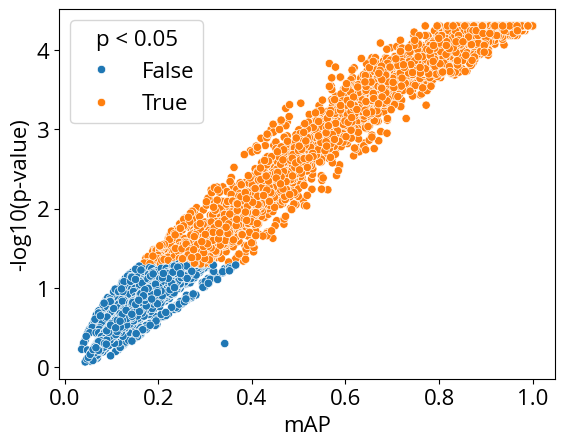

In [9]:
sns.scatterplot(data=tech_map, x="mAP", y="-log10(p-value)", hue="p < 0.05")

<Axes: xlabel='mAP', ylabel='-log10(q-value)'>

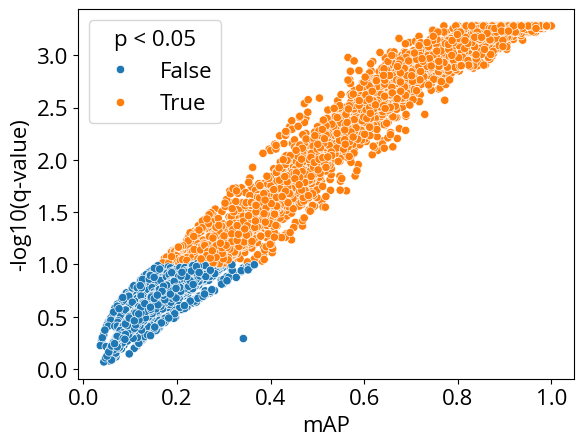

In [10]:
sns.scatterplot(data=tech_map, x="mAP", y="-log10(q-value)", hue="p < 0.05")

In [11]:
df = tech_map

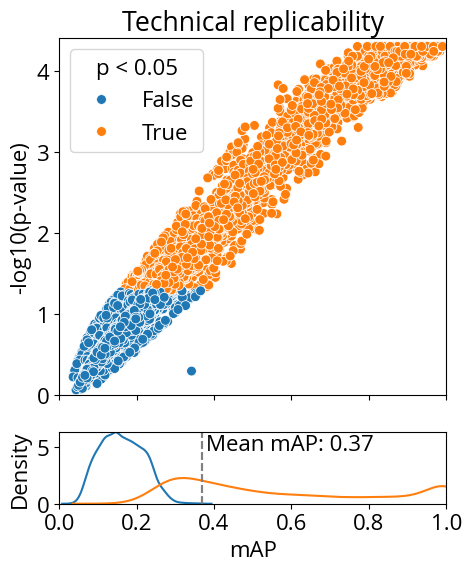

In [12]:
def remove_inner_ticklabels(fig: plt.Figure):
    """
    Remove inner ticklabels from a figure.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Figure to remove inner ticklabels from.
    """
    for ax in fig.axes:
        try:
            ax.label_outer()
        except AttributeError:
            pass


fig, axes = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [5, 1]})

mean_map = df['mAP'].mean()
sns.scatterplot(
    ax=axes[0], 
    data=df, 
    x='mAP', 
    y='-log10(p-value)', 
    hue='p < 0.05',
    s=50
)
axes[0].set_title("Technical replicability")


axes[0].set_xlabel("")
axes[0].set_ylim(0, max(df['-log10(p-value)'])+0.1)
# sns.move_legend(axes[0, 0], "upper left")

# Second Row: KDE plots
max_kde_y = 0
mean_map = df['mAP'].mean()
for p_value in df['p < 0.05'].unique():
    ax = sns.kdeplot(
        ax=axes[1],
        data=df[df['p < 0.05'] == p_value],
        x='mAP', 
        label=str(p_value)
    )
    max_kde_y = max(max_kde_y, max(ax.lines[-1].get_ydata()))
    axes[1].axvline(mean_map, color='grey', linestyle='--')
# axes[1].set_ylabel("")
axes[1].set_ylim(0, max_kde_y)
axes[1].text(mean_map+0.01, 0.75, f"Mean mAP: {mean_map:.2f}", transform=axes[1].transAxes)

for ax in axes.flat:
    ax.set_xlim(0, 1)  # Set x-axis limit to 0-1 for all subplots

remove_inner_ticklabels(fig)
plt.tight_layout()
plt.show()


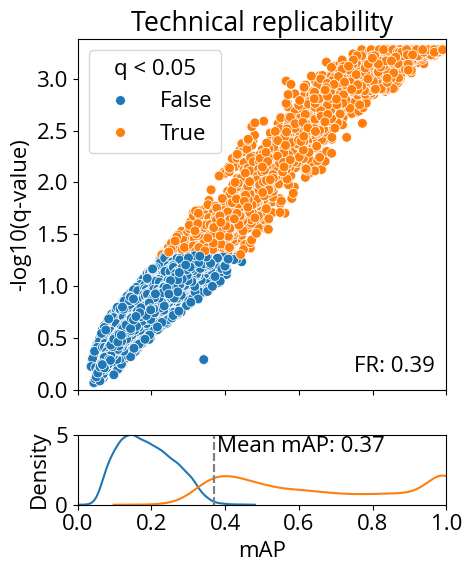

In [13]:
def remove_inner_ticklabels(fig: plt.Figure):
    """
    Remove inner ticklabels from a figure.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Figure to remove inner ticklabels from.
    """
    for ax in fig.axes:
        try:
            ax.label_outer()
        except AttributeError:
            pass


fig, axes = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [5, 1]})

mean_map = df['mAP'].mean()
fr = df['q < 0.05'].mean()
sns.scatterplot(
    ax=axes[0], 
    data=df, 
    x='mAP', 
    y='-log10(q-value)', 
    hue='q < 0.05',
    s=50
)
axes[0].set_title("Technical replicability")
axes[0].text(0.75, 0.05, f"FR: {fr:.2f}", transform=axes[0].transAxes)

axes[0].set_xlabel("")
axes[0].set_ylim(0, max(df['-log10(q-value)'])+0.1)
# sns.move_legend(axes[0, 0], "upper left")

# Second Row: KDE plots
max_kde_y = 0
mean_map = df['mAP'].mean()
for p_value in df['q < 0.05'].unique():
    ax = sns.kdeplot(
        ax=axes[1],
        data=df[df['q < 0.05'] == p_value],
        x='mAP', 
        label=str(p_value)
    )
    max_kde_y = max(max_kde_y, max(ax.lines[-1].get_ydata()))
    axes[1].axvline(mean_map, color='grey', linestyle='--')
# axes[1].set_ylabel("")
axes[1].set_ylim(0, max_kde_y)
axes[1].text(mean_map+0.01, 0.75, f"Mean mAP: {mean_map:.2f}", transform=axes[1].transAxes)

for ax in axes.flat:
    ax.set_xlim(0, 1)  # Set x-axis limit to 0-1 for all subplots

remove_inner_ticklabels(fig)
plt.tight_layout()
plt.show()


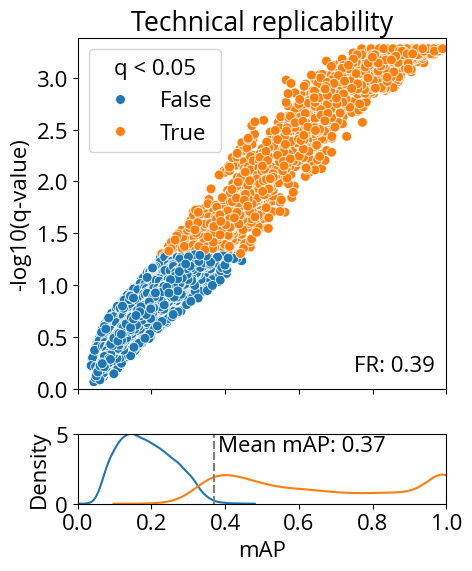

In [14]:
df = tech_map_rep_5

def remove_inner_ticklabels(fig: plt.Figure):
    """
    Remove inner ticklabels from a figure.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Figure to remove inner ticklabels from.
    """
    for ax in fig.axes:
        try:
            ax.label_outer()
        except AttributeError:
            pass


fig, axes = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [5, 1]})

mean_map = df['mAP'].mean()
fr = df['q < 0.05'].mean()
sns.scatterplot(
    ax=axes[0], 
    data=df, 
    x='mAP', 
    y='-log10(q-value)', 
    hue='q < 0.05',
    s=50
)
axes[0].set_title("Technical replicability")
axes[0].text(0.75, 0.05, f"FR: {fr:.2f}", transform=axes[0].transAxes)

axes[0].set_xlabel("")
axes[0].set_ylim(0, max(df['-log10(q-value)'])+0.1)
# sns.move_legend(axes[0, 0], "upper left")

# Second Row: KDE plots
max_kde_y = 0
mean_map = df['mAP'].mean()
for p_value in df['q < 0.05'].unique():
    ax = sns.kdeplot(
        ax=axes[1],
        data=df[df['q < 0.05'] == p_value],
        x='mAP', 
        label=str(p_value)
    )
    max_kde_y = max(max_kde_y, max(ax.lines[-1].get_ydata()))
    axes[1].axvline(mean_map, color='grey', linestyle='--')
# axes[1].set_ylabel("")
axes[1].set_ylim(0, max_kde_y)
axes[1].text(mean_map+0.01, 0.75, f"Mean mAP: {mean_map:.2f}", transform=axes[1].transAxes)

for ax in axes.flat:
    ax.set_xlim(0, 1)  # Set x-axis limit to 0-1 for all subplots

remove_inner_ticklabels(fig)
plt.tight_layout()
plt.show()


In [15]:
tech_map_rep_5


,Metadata_broad_sample,mAP,-log10(p-value),q_value,-log10(q-value),p < 0.05,q < 0.05
0,ccsbBroad304_00001,0.117705,0.537173,0.321935,0.492232,False,False
1,ccsbBroad304_00002,0.326586,1.582045,0.062658,1.203027,True,False
2,ccsbBroad304_00003,0.656475,2.925116,0.005483,2.260959,True,True
3,ccsbBroad304_00007,0.882976,4.040845,0.000736,3.132957,True,True
4,ccsbBroad304_00008,0.259185,1.223691,0.111108,0.954253,False,False
...,...,...,...,...,...,...,...
13734,ccsbBroad304_16168,0.198247,0.963274,0.165118,0.782204,False,False
13735,ccsbBroad304_16169,0.118154,0.580775,0.297767,0.526124,False,False
13736,ccsbBroad304_16170,0.480805,2.177285,0.021953,1.658505,True,True
13737,ccsbBroad304_16171,0.990000,4.301052,0.000524,3.280904,True,True


In [16]:
tech_map_rep_5["q < 0.05"].sum()

5263

In [17]:
tech_map_rep_5.drop(columns=["p < 0.05"], inplace=True)

tech_map_rep_5.rename(columns={"-log10(q-value)": "-log10(mAP p-value)", "q < 0.05": "p < 0.05"}, inplace=True)
tech_map_rep_5

/tmp/ipykernel_71281/3605552868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tech_map_rep_5.drop(columns=["p < 0.05"], inplace=True)
/tmp/ipykernel_71281/3605552868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tech_map_rep_5.rename(columns={"-log10(q-value)": "-log10(mAP p-value)", "q < 0.05": "p < 0.05"}, inplace=True)


,Metadata_broad_sample,mAP,-log10(p-value),q_value,-log10(mAP p-value),p < 0.05
0,ccsbBroad304_00001,0.117705,0.537173,0.321935,0.492232,False
1,ccsbBroad304_00002,0.326586,1.582045,0.062658,1.203027,False
2,ccsbBroad304_00003,0.656475,2.925116,0.005483,2.260959,True
3,ccsbBroad304_00007,0.882976,4.040845,0.000736,3.132957,True
4,ccsbBroad304_00008,0.259185,1.223691,0.111108,0.954253,False
...,...,...,...,...,...,...
13734,ccsbBroad304_16168,0.198247,0.963274,0.165118,0.782204,False
13735,ccsbBroad304_16169,0.118154,0.580775,0.297767,0.526124,False
13736,ccsbBroad304_16170,0.480805,2.177285,0.021953,1.658505,True
13737,ccsbBroad304_16171,0.990000,4.301052,0.000524,3.280904,True


/tmp/ipykernel_71281/1424496636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tech_map_rep_5["const"] = "dataset: ORF"
/dgx1nas1/storage/data/akalinin/projects/grit-benchmark/1.calculate-metrics/orf/../plot_utils.py:105: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


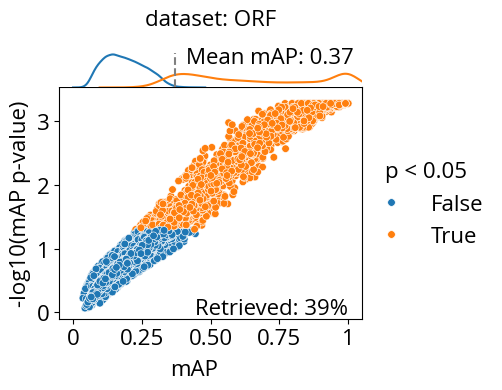

In [18]:
tech_map_rep_5["const"] = "dataset: ORF"

plot_map_x3(tech_map_rep_5, "const", "", s=30, pr_x=0.45, pr_y=0.02, l_x=1.1, l_y=0.58)

In [20]:
tech_map_rep_5

,Metadata_broad_sample,mAP,-log10(p-value),q_value,-log10(mAP p-value),p < 0.05,const
0,ccsbBroad304_00001,0.117705,0.537173,0.321935,0.492232,False,dataset: ORF
1,ccsbBroad304_00002,0.326586,1.582045,0.062658,1.203027,False,dataset: ORF
2,ccsbBroad304_00003,0.656475,2.925116,0.005483,2.260959,True,dataset: ORF
3,ccsbBroad304_00007,0.882976,4.040845,0.000736,3.132957,True,dataset: ORF
4,ccsbBroad304_00008,0.259185,1.223691,0.111108,0.954253,False,dataset: ORF
...,...,...,...,...,...,...,...
13734,ccsbBroad304_16168,0.198247,0.963274,0.165118,0.782204,False,dataset: ORF
13735,ccsbBroad304_16169,0.118154,0.580775,0.297767,0.526124,False,dataset: ORF
13736,ccsbBroad304_16170,0.480805,2.177285,0.021953,1.658505,True,dataset: ORF
13737,ccsbBroad304_16171,0.990000,4.301052,0.000524,3.280904,True,dataset: ORF
